In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/ppi_mips.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
groups = np.loadtxt('./datasets/ppi_mips.class', dtype = 'float')
feature_list = [groups]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_ppi_mips', ref_nodes) 
            np.save('results/info_ref_nodes_ppi_mips', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  28.0  gap  [0.94477965]  volume:  1861.0  size: 33 conductance:  0.4325631380977969
Reached
Number of feature 0 Feature value  82.0  gap  [0.91787315]  volume:  1488.0  size: 32 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  127.0  gap  [0.94916577]  volume:  1487.0  size: 29 conductance:  0.4539340954942838
Reached
Number of feature 0 Feature value  202.0  gap  [0.91949736]  volume:  9720.0  size: 81 conductance:  0.3333333333333333
Reached
Number of feature 0 Feature value  208.0  gap  [0.91905067]  volume:  4788.0  size: 57 conductance:  0.3333333333333333


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [6]:
ref_nodes = np.load('results/ref_nodes_ppi_mips.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_ppi_mips.npy') 

## Visualize the ground truth clusters

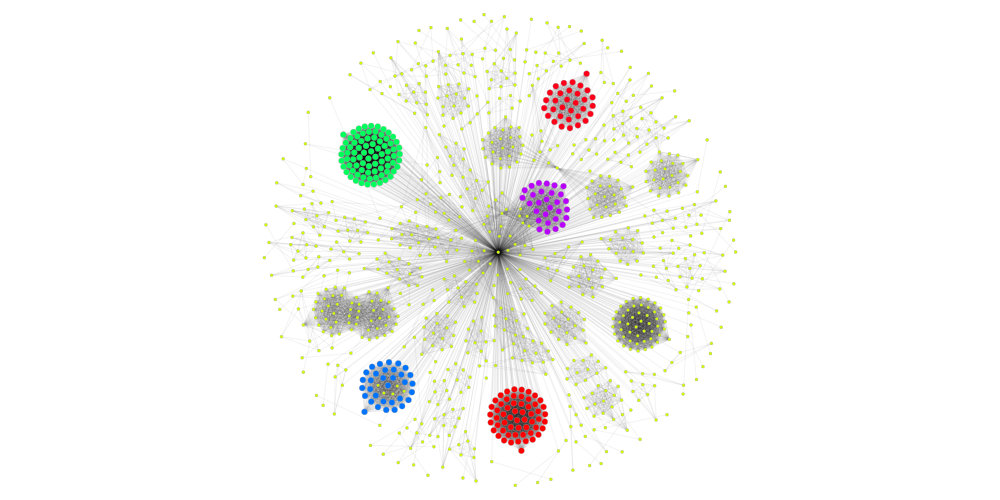

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x131e66c88, at 0x131e5af98>

In [7]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

c_map = get_cmap(g_gtool.num_vertices())

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map)

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [8]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_ppi_mips', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_ppi_mips', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_ppi_mips', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_ppi_mips', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_ppi_mips', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_ppi_mips', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_ppi_mips', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_ppi_mips', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_ppi_mips', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_ppi_mips', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_ppi_mips', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_ppi_mips', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_ppi_mips', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_ppi_mips', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_ppi_mips', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_ppi_mips', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_ppi_mips', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_ppi_mips', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_ppi_mips', cuts_acl_ALL) 
    
    np.save('results/nodes_ppi_mips', nodes)

16
outer: 0 number of node:  362  completed:  0.0  degree:  51.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  355  completed:  0.0625  degree:  58.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  358  completed:  0.125  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  365  completed:  0.1875  degree:  48.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0


/usr/local/lib/python3.7/site-packages/localgraphclustering/spectral_clustering.py:95: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.

/usr/local/lib/python3.7/site-packages/localgraphclustering/approximate_PageRank.py:110: UserWarning:

The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.



outer: 0 number of node:  374  completed:  0.25  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  348  completed:  0.3125  degree:  65.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  372  completed:  0.375  degree:  41.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  367  completed:  0.4375  degree:  46.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  376  completed:  0.5  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  339  completed:  0.5625  degree:  74.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245

outer: 3 number of node:  95  completed:  0.25  degree:  127.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  87  completed:  0.275  degree:  135.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  81  completed:  0.3  degree:  141.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  142  completed:  0.325  degree:  80.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  84  completed:  0.35  degree:  138.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  79  completed:  0.375  degree:  143.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  112  completed:  0.4  degree:  110.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node: 

## Improve the results found by the spectral algorithm using MQI

In [9]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_mqi_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_mqi_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_mqi_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_mqi_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_mqi_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_mqi_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_mqi_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_mqi_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_mqi_ppi_mips', f1score_acl_flow) 

16
outer: 0 number of node:  362  completed:  0.0  degree:  51.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  355  completed:  0.0625  degree:  58.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  358  completed:  0.125  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  365  completed:  0.1875  degree:  48.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  374  completed:  0.25  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  348  completed:  0.3125  degree:  65.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087

/usr/local/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py:46: UserWarning:

The weights of the graph will be discarded. Use "crd" if you want to keep them.



outer: 1 number of node:  483  completed:  0.25  degree:  31.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  462  completed:  0.3125  degree:  52.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  467  completed:  0.375  degree:  47.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  455  completed:  0.4375  degree:  59.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  453  completed:  0.5  degree:  61.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  470  completed:  0.5625  degree:  44.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of node:  473  completed:  0.625  degree:  41.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 1 number of n

outer: 3 number of node:  63  completed:  0.9  degree:  159.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  98  completed:  0.925  degree:  124.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  100  completed:  0.95  degree:  122.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  64  completed:  0.975  degree:  158.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
28
outer: 4 number of node:  11  completed:  0.0  degree:  102.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 4 number of node:  9  completed:  0.03571428571428571  degree:  104.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 4 number of node:  37  completed:  0.07142857142857142  degree:  76.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall: 

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [10]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0.00000000001)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_flowImprove_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_flowImprove_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_flowImprove_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_flowImprove_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_flowImprove_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_flowImprove_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_flowImprove_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_flowImprove_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_flowImprove_ppi_mips', f1score_acl_flow) 

16
outer: 0 number of node:  362  completed:  0.0  degree:  51.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  355  completed:  0.0625  degree:  58.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  358  completed:  0.125  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  365  completed:  0.1875  degree:  48.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0


/usr/local/lib/python3.7/site-packages/localgraphclustering/flow_clustering.py:52: UserWarning:

The weights of the graph will be discarded. Use "crd" if you want to keep them.



outer: 0 number of node:  374  completed:  0.25  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  348  completed:  0.3125  degree:  65.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  372  completed:  0.375  degree:  41.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  367  completed:  0.4375  degree:  46.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  376  completed:  0.5  degree:  37.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  339  completed:  0.5625  degree:  74.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245

outer: 3 number of node:  79  completed:  0.375  degree:  143.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  112  completed:  0.4  degree:  110.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  76  completed:  0.425  degree:  146.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  70  completed:  0.45  degree:  152.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  82  completed:  0.475  degree:  140.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  91  completed:  0.5  degree:  131.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  128  completed:  0.525  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [11]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)    
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter1_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter1_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter1_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter1_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter1_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter1_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter1_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter1_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter1_ppi_mips', f1score_acl_flow) 

16
outer: 0 number of node:  362  completed:  0.0  degree:  51.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  355  completed:  0.0625  degree:  58.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  358  completed:  0.125  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  365  completed:  0.1875  degree:  48.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  374  completed:  0.25  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  348  completed:  0.3125  degree:  65.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087

outer: 3 number of node:  84  completed:  0.35  degree:  138.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  79  completed:  0.375  degree:  143.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  112  completed:  0.4  degree:  110.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  76  completed:  0.425  degree:  146.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  70  completed:  0.45  degree:  152.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  82  completed:  0.475  degree:  140.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  91  completed:  0.5  degree:  131.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node: 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [12]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter2_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter2_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter2_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter2_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter2_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter2_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter2_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter2_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter2_ppi_mips', f1score_acl_flow) 

16
outer: 0 number of node:  362  completed:  0.0  degree:  51.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  355  completed:  0.0625  degree:  58.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  358  completed:  0.125  degree:  55.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  365  completed:  0.1875  degree:  48.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  374  completed:  0.25  degree:  39.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087245139877 recall:  1.0
outer: 0 number of node:  348  completed:  0.3125  degree:  65.0
conductance:  0.3333333333333333 f1score:  0.9375314861460956 precision:  0.8824087

outer: 3 number of node:  112  completed:  0.4  degree:  110.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  76  completed:  0.425  degree:  146.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  70  completed:  0.45  degree:  152.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  82  completed:  0.475  degree:  140.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  91  completed:  0.5  degree:  131.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  128  completed:  0.525  degree:  94.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node:  73  completed:  0.55  degree:  149.0
conductance:  0.3333333333333333 f1score:  1.0 precision:  1.0 recall:  1.0
outer: 3 number of node: 

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [ ]:
nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_pre_acl = np.load('results/cuts_best_pre_acl_ppi_mips.npy')
cuts_best_pre_acl = cuts_best_pre_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_pre_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_best_acl_flow_localflowImprove_parameter3_ppi_mips', size_clust_acl_flow) 
    np.save('results/external_cond_best_acl_flow_localflowImprove_parameter3_ppi_mips', external_cond_acl_flow)
    np.save('results/vol_best_acl_flow_localflowImprove_parameter3_ppi_mips', vol_acl_flow) 
    np.save('results/gap_best_acl_flow_localflowImprove_parameter3_ppi_mips', gap_acl_flow) 
    np.save('results/cuts_best_acl_flow_localflowImprove_parameter3_ppi_mips', cuts_acl_flow) 
    np.save('results/true_positives_best_acl_flow_localflowImprove_parameter3_ppi_mips', true_positives_acl_flow)
    np.save('results/recall_best_acl_flow_localflowImprove_parameter3_ppi_mips', recall_acl_flow) 
    np.save('results/precision_best_acl_flow_localflowImprove_parameter3_ppi_mips', precision_acl_flow) 
    np.save('results/f1score_best_acl_flow_localflowImprove_parameter3_ppi_mips', f1score_acl_flow) 

## Load data for plots

In [144]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_ppi_mips.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_best_acl_flow_mqi_ppi_mips.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_best_acl_flow_mqi_ppi_mips.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_best_acl_flow_mqi_ppi_mips.npy')
f1_mqi = f1_mqi[()]
precision_best_pre_acl = np.load('results/precision_best_pre_acl_ppi_mips.npy')
precision_best_pre_acl = precision_best_pre_acl[()]
recall_best_pre_acl = np.load('results/recall_best_pre_acl_ppi_mips.npy')
recall_best_pre_acl = recall_best_pre_acl[()]
f1score_best_pre_acl = np.load('results/f1score_best_pre_acl_ppi_mips.npy')
f1score_best_pre_acl = f1score_best_pre_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_best_acl_flow_flowImprove_ppi_mips.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_best_acl_flow_flowImprove_ppi_mips.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_best_acl_flow_flowImprove_ppi_mips.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter1_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter2_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_best_acl_flow_localflowImprove_parameter3_ppi_mips.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

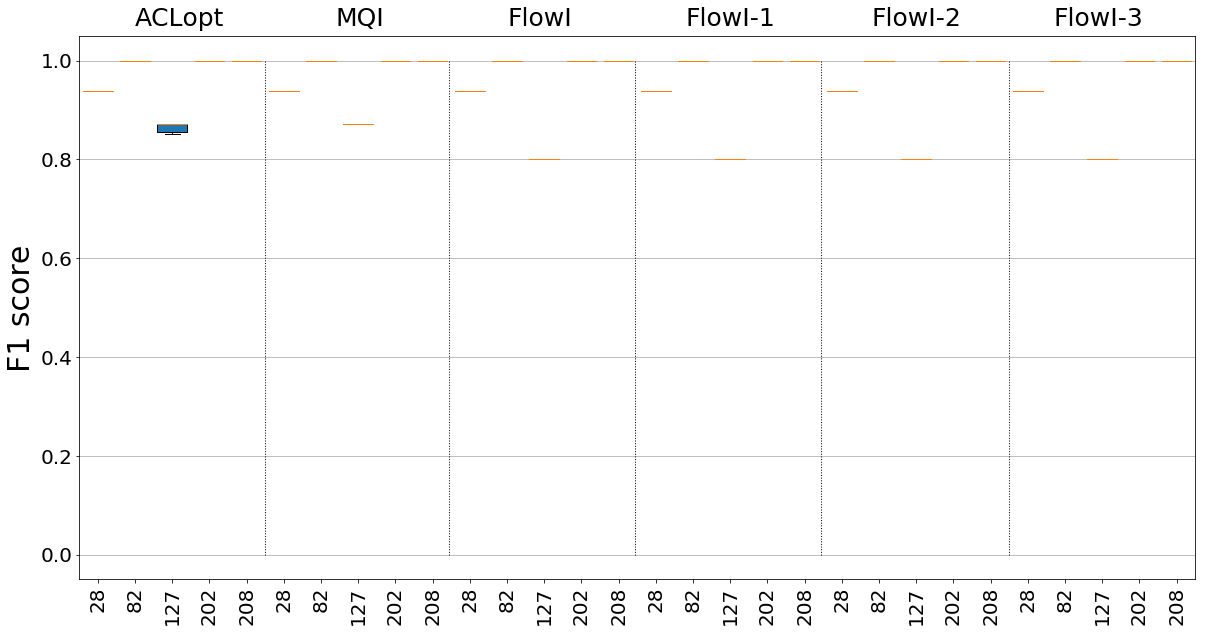

In [145]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_pre_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate scatter plot for precision

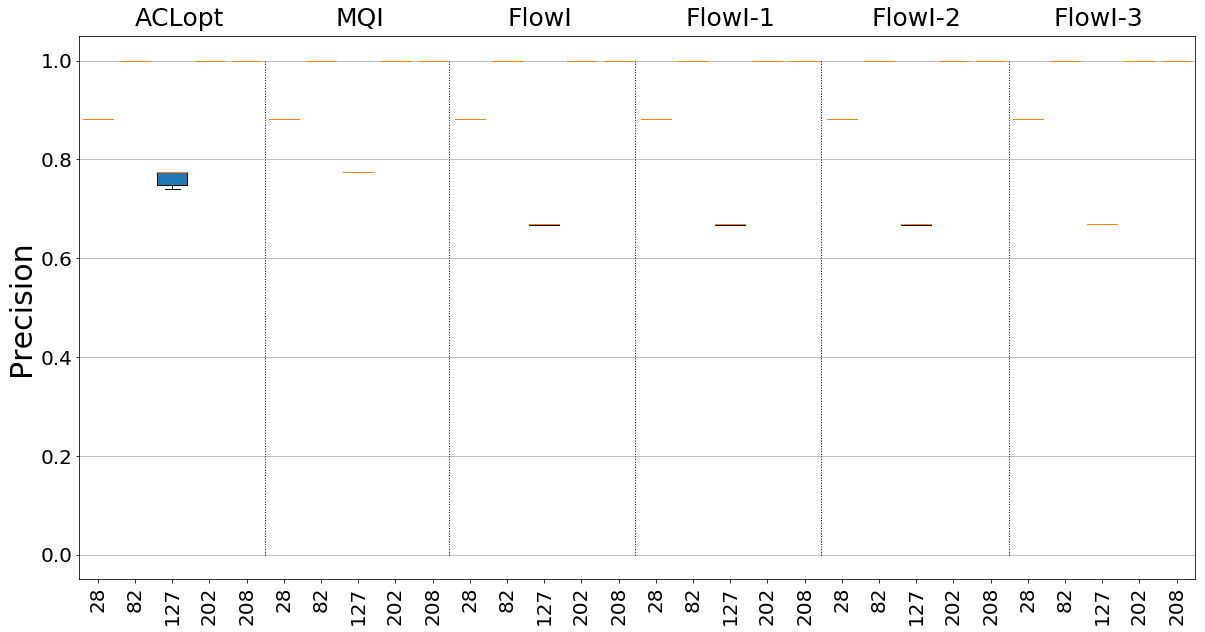

In [146]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate scatter plot for recall

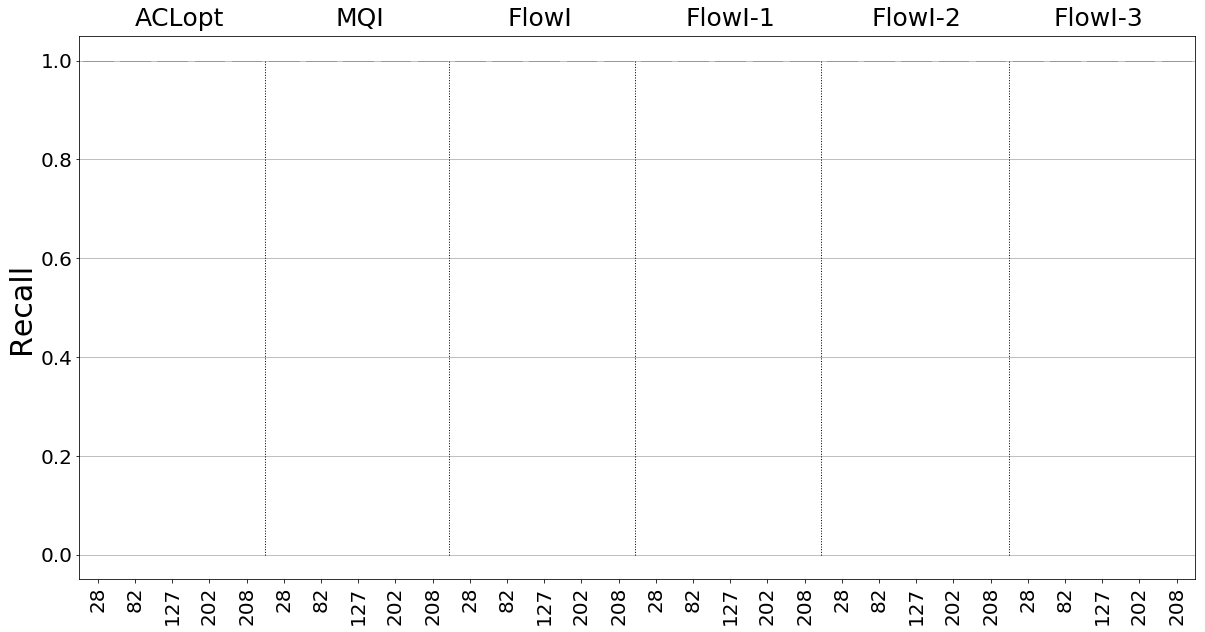

In [147]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_pre_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(2, 1.07, 'ACLopt', fontsize=25)
plt.text(7.4, 1.07, 'MQI', fontsize=25)
plt.text(12.0, 1.07, 'FlowI', fontsize=25)
plt.text(16.8, 1.07, 'FlowI-1', fontsize=25)
plt.text(21.8, 1.07, 'FlowI-2', fontsize=25)
plt.text(26.7, 1.07, 'FlowI-3', fontsize=25)


#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([5.5, 5.5], [0, 1], 'k:', linewidth=1)
plt.plot([10.45, 10.45], [0, 1], 'k:', linewidth=1)
plt.plot([15.45, 15.45], [0, 1], 'k:', linewidth=1)
plt.plot([20.45, 20.45], [0, 1], 'k:', linewidth=1)
plt.plot([25.5, 25.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_ppi_mips_Optimal.png')

plt.show()

## Generate precision/recall and F1 scores

In [148]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_pre_acl[i,j])
        temp_rec.append(recall_best_pre_acl[i,j])
        temp_f1.append(f1score_best_pre_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 28.0 Precision 0.8824087245139877 Recall 1.0 F1 0.9375314861460956
Feature: 82.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 127.0 Precision 0.7736732570239334 Recall 1.0 F1 0.8723965972425932
Feature: 202.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 208.0 Precision 1.0 Recall 1.0 F1 1.0
Results for MQI
Feature: 28.0 Precision 0.8824087245139877 Recall 1.0 F1 0.9375314861460956
Feature: 82.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 127.0 Precision 0.7736732570239334 Recall 1.0 F1 0.8723965972425932
Feature: 202.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 208.0 Precision 1.0 Recall 1.0 F1 1.0
Results for FlowI
Feature: 28.0 Precision 0.8824087245139877 Recall 1.0 F1 0.9375314861460956
Feature: 82.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 127.0 Precision 0.6689158794421952 Recall 1.0 F1 0.8016172506738545
Feature: 202.0 Precision 1.0 Recall 1.0 F1 1.0
Feature: 208.0 Precision 1.0 Recall 1.0 F1 1.0
Results for FlowI-1
Feature: 28.0 Precision 0.8824087245139877 Recal